#분석용 데이터 구축_서지현

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. 머리말 Introduction
Springleaf는 고객에게 개인 및 자동차 대출을 제공함으로써 고객이 자신의 삶과 재정을 통제할 수 있도록 돕습니다.
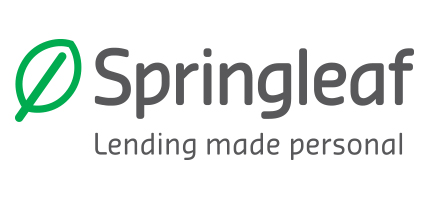
DM은 Springleaf가 대출이 필요한 고객과 연락할 수 있는 주요한 방법 중 하나이며, 그들의 타깃인 잠재적인 고객층에 포커싱하고 있는가는 중요합니다.

## 1-1. 제시된 과제
-> 어떤 고객이 DM에 응답할 것인가를 예측할 것

### 1-1-1. 데이터에 관하여
익명화된 고객 정보가 담긴 고차원 데이터(high-dimensional datasets)가 제공됩니다. 각 행은 한 명의 고객을 나타내며 응답 변수는 바이너리(Binary)이며 "target"으로 표시됩니다.테스트 세트의 모든 행에 대한 대상 변수를 예측해야 합니다.

연속/범주형 값이 혼합되어 구성되며, 데이터에는 결측값을 뜻하는 "placeholder"값이 발생합니다. Springleaf의 내부 시스템과 일치하도록 의도적으로 보존했습니다. 특징, 그 가치 및 유형의 의미는,"있는 그대로" 제공됩니다.

# 2. 패키지 불러오기

## 2-1.Import 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from eli5.sklearn import PermutationImportance
from catboost import CatBoostClassifier,Pool
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.patches as patch
import matplotlib.pyplot as plt
from sklearn.svm import NuSVR
from scipy.stats import norm
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import eli5
import time
import glob
import sys
import os
import gc

## 2-2.Version

In [ ]:
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('Python: {}'.format(sys.version))

# 3.EDA

## 3-1. 데이터 불러오기

In [ ]:
print(os.listdir("../input/springleaf-marketing-response/"))

*zip형태로 제공된 자료는 아래의 과정을 거쳐 활용함*

## 3-1-1. 데이터 압축풀기

In [ ]:
#Zipfile 기능사용

import zipfile
#test.csv
with zipfile.ZipFile("../input/springleaf-marketing-response/test.csv.zip","r") as zf:
    zf.extractall(".")
#train.csv
with zipfile.ZipFile("../input/springleaf-marketing-response/train.csv.zip","r") as zf:
    zf.extractall(".")
#sample_submission.csv 
with zipfile.ZipFile("../input/springleaf-marketing-response/sample_submission.csv.zip","r") as zf:
    zf.extractall(".")

In [ ]:
from subprocess import check_output
print(check_output(["ls", "test.csv"]).decode("utf8"))
print(check_output(["ls", "train.csv"]).decode("utf8"))
print(check_output(["ls", "sample_submission.csv"]).decode("utf8"))

In [ ]:
test=pd.read_csv("./test.csv")
train=pd.read_csv("./train.csv")
sample_Sub=pd.read_csv("./sample_submission.csv")

## 3-2. 데이터 분석

train 데이터 (행: 145,231/ 열: 1,934)

* ID
* 1932개의 변수:VAR_0001 ~ VAR_1934
* target

In [ ]:
columns = list(train.columns)

for i in range(1, 1935):
    # i ~ 1, 2, ... 1934
    varname = 'VAR_{:04d}'.format(i)
    if not (varname in columns):
        print(varname)

연속형 숫자 중 없는 VAR 데이터
* VAR_0218
* VAR_0240

In [ ]:
print(train.shape)
print(train.info())
train.head()

test 데이터 (행: 145,232/ 열: 1,933)

* ID
* 1932개의 변수:VAR_0001 ~ VAR_1934

In [ ]:
print(test.shape)
print(test.info())
test.head()

### 3-2-1. Descibe()

* train 및 test 데이터의 최소값, 최대값, 평균값, 표준값은 근사한 값을 보인다.

In [ ]:
%%time 
train.describe()

In [ ]:
%%time
test.describe()

### 3-2-2. 결측값 확인

*결측값이 존재하므로 특성, 목적에 맞게 처리해야 한다.*

In [ ]:
def missing_check(data):
    tf=data.isna().sum().any()
    if tf==True:
        total = data.isnull().sum()
        percent = (data.isnull().sum()/data.isnull().count()*100)
        output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        data_type = []
        for col in data.columns:
            dtype = str(data[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(np.transpose(output))
    else:
        return(False)

In [ ]:
missing_check(train)

In [ ]:
missing_check(test)

### 3-2-3. 종속변수 Target Variable

In [ ]:
sns.countplot(train.target)
plt.title("")

In [ ]:
#수치
print(train['target'].value_counts())
#비율
print(round(train.target.value_counts() *100/ train.target.count(),2))

=>비대칭 데이터(Imbalanced Data)

응답하지 않을 고객 수(0)와 응답할 것으로 예상되는 고객(1)의 비율은 약 76%, 23%로 차이를 보인다.

## 3-3.데이터 다운사이징

1. 변환 전 약 2.1+ GB -> 변환 후 약 584.8+MB

데이터 다운사이징 : 참고// https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

In [ ]:
#Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [ ]:
test, NAlist = reduce_mem_usage(test)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

In [ ]:
train, NAlist = reduce_mem_usage(train)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

In [ ]:
train.info()

In [ ]:
test.info()

In [ ]:
train_dropna=X_train.dropna(axis=1)
train_dropna=X_train.dropna()
test_dropna=X_train.dropna(axis=1)
test_dropna=X_train.dropna()

In [ ]:
text

## 4. Modelling

##4-1. Split data

In [ ]:
columns=["target","ID"]
X = train.drop(columns,axis=1)
y = train["target"]

In [ ]:
X_test  = test.drop("ID",axis=1)

In [ ]:
#테스트용으로 사이즈 추가로 축소
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.5, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,test_size=0.5, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,test_size=0.5, random_state=1)

In [ ]:
# X_train.info(), X_test.info() -> 73.1+MB

In [ ]:
#5-2. Eli5
perm_imp = PermutationImportance(rfc, random_state=1).fit(X_test, y_test)